## Check some statistics for issues

In [1]:
import pandas as pd
import ray
import dask.dataframe as dd
from pathlib import Path
import numpy as np
from tqdm.auto import tqdm
import json
import gzip
import json

In [ ]:
import dask
dask.config.set({'logging.distributed': 'error'})
import logging


In [ ]:
set([1, 3, 5]).intersection(set([3, 10, 12]))

In [2]:
from toolkit_run.ray.server import LabRayToolkitServer
server = LabRayToolkitServer()
server.dashboard_url

'https://d836708a-223a-443a-be5c-78c61f5498a5-8000.job.console.elementai.com'

In [3]:
server.scale_cluster(60)

'OK'

In [ ]:
ray.shutdown()

In [4]:
path = Path('/dataset/gharchives_2015')
files = list(path.glob('*'))

In [5]:
def enum_jsongz_lines(file):
    with gzip.open(file, "r") as f:
        for line in f:
            try:
                yield json.loads(line)
            except Exception:
                continue

In [ ]:
event_types = set(['ForkEvent'])
events = []
to_break = False
for file in tqdm(files):
    for line in enum_jsongz_lines(file):
        try:
            event_type = line['type']
            if event_type in event_types:
                to_break = True
                break
        except Exception:
            print(line)
            raise
    if to_break:
        break

In [6]:
def parse_fork_event(line):
    return {
        'actor_login': line['actor']['login'],
        'src_repo': line['repo']['name'],
        'event_created_at': line['created_at']
    }

def parse_file(file):
    data = []
    for line in enum_jsongz_lines(file):
        try:
            event_type = line['type']
            if event_type == 'ForkEvent':
                data.append(parse_fork_event(line))
        except Exception:
            continue
    if len(data) > 0:
        return pd.DataFrame(data)
    else:
        return None
    
@ray.remote(num_cpus=2)
def process(file):
    return parse_file(file)

In [8]:
res = []
for file in files:
    res.append(process.remote(file))
res = ray.get(res)

In [9]:
df = pd.concat(res)

In [11]:
 df['event_created_at'] = pd.to_datetime(df['event_created_at'], errors='coerce')

In [12]:
groups = df.groupby('src_repo')

In [13]:
df1 = pd.DataFrame()

In [14]:
df1['count'] = groups['actor_login'].count()

In [16]:
df1['event_min_datetime'] =  groups['event_created_at'].min()
df1['event_max_datetime'] =  groups['event_created_at'].max()

In [17]:
df1.sort_values('count')

,count,event_min_datetime,event_max_datetime
src_repo,,,
fork-apps/simple-licensing-api,1,2020-02-25 16:51:00+00:00,2020-02-25 16:51:00+00:00
jangel97/gsx_practica1_sistemes,1,2019-02-06 19:18:17+00:00,2019-02-06 19:18:17+00:00
jangelcp/pruebaculo,1,2021-08-02 01:21:38+00:00,2021-08-02 01:21:38+00:00
jangeles/jaenv,1,2021-08-03 16:41:53+00:00,2021-08-03 16:41:53+00:00
jangelesg/AWAE-OSWE,1,2021-07-09 12:25:23+00:00,2021-07-09 12:25:23+00:00
...,...,...,...
github/gitignore,94734,2015-01-01 03:43:22+00:00,2022-03-31 23:02:06+00:00
tensorflow/tensorflow,104981,2015-11-09 13:40:17+00:00,2022-03-31 19:51:54+00:00
rdpeng/ProgrammingAssignment2,132038,2015-01-01 20:40:47+00:00,2022-03-31 23:50:11+00:00


/tmp/ipykernel_42305/911852571.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


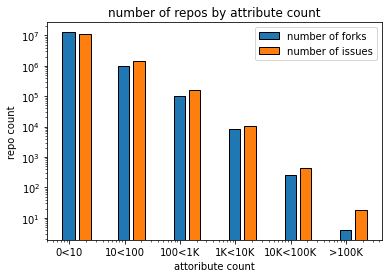

In [32]:
import numpy as np
import matplotlib.pyplot as plt
hist, bins = np.histogram(df1['count'], bins=[0, 10, 100, 1000, 10000, 100000, 1000000])
hist2, bins2 = np.histogram(df2['count'], bins=[0, 10, 100, 1000, 10000, 100000, 1000000])
fig, ax = plt.subplots()
ax.bar(bins[1:]-np.diff(bins)/4, hist, width=np.diff(bins)/2, log=True,ec="k", align="edge", label='number of forks')
ax.bar(bins2[1:]+np.diff(bins2)/2, hist2, width=np.diff(bins2), log=True,ec="k", align="edge", label='number of issues')
ax.set_xscale("log")
ax.set_title('number of repos by attribute count')
ax.set_xlabel('attoribute count')
ax.set_ylabel('repo count')

fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[2] = '0<10'
labels[3] = '10<100'
labels[4] = '100<1K'
labels[5] = '1K<10K'
labels[6] = '10K<100K'
labels[7] = '>100K'

ax.set_xticklabels(labels)

plt.legend()

plt.show()

In [19]:
df1.to_parquet('/repo_workdir/forks_per_repos_all.parquet')

In [20]:
df2 = pd.read_parquet('/repo_workdir/issues_per_repos_all.parquet')

In [ ]:
grouped = df.groupby('repo_name')

## end count number of issues